# SPAM Detection

### Installations and Imports

In [6]:
%pip install numpy pandas tensorflow matplotlib seaborn nltk scikit-learn wordcloud

# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\popsi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data and make columns uniform

In [7]:
# Load 'lingSpam'
df_ling = pd.read_csv('data\lingSpam.csv')

# Load 'enronSpamSubset'
df_enron = pd.read_csv('data\enronSpamSubset.csv')

# Load 'completeSpamAssassin' 
df_sa = pd.read_csv('data\completeSpamAssassin.csv')

# check columns in dataframes
print(df_ling.columns)
print(df_enron.columns)
print(df_sa.columns)

# remove extra column from enron data
df_enron = df_enron.drop(columns=['Unnamed: 0.1'])


print('Removing exta column...')
print(df_ling.columns)
print(df_enron.columns)
print(df_sa.columns)

df_enron.head()


Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0.1', 'Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Removing exta column...
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')
Index(['Unnamed: 0', 'Body', 'Label'], dtype='object')


,Unnamed: 0,Body,Label
0,2469,Subject: stock promo mover : cwtd\r\n * * * ur...,1
1,5063,Subject: are you listed in major search engine...,1
2,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,"Subject: "" bidstogo "" is places to go , things...",1


### Combine datasets

In [8]:
df_combined = pd.concat([df_sa, df_enron, df_ling])
df_combined.drop('Unnamed: 0', axis = 1, inplace=True)
df_combined.head()

,Body,Label
0,\r\nSave up to 70% on Life Insurance.\r\nWhy S...,1
1,1) Fight The Risk of Cancer!\r\nhttp://www.adc...,1
2,1) Fight The Risk of Cancer!\r\nhttp://www.adc...,1
3,##############################################...,1
4,I thought you might like these:\r\n1) Slim Dow...,1


### Check for data imbalance

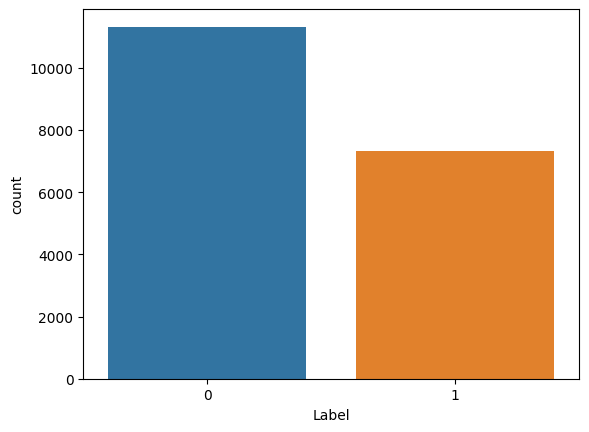

In [9]:
sns.countplot(x='Label', data=df_combined)
plt.show()

Not imbalanced enough to require over or under sampling

### Clean up unneeded words and punctuation

In [10]:
# remove blanks
df_combined = df_combined.dropna()

#  remove the word "Subject" from every email

df_combined['Body'] = df_combined['Body'].str.replace('Subject', '')

# remove punctuation
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
df_combined['Body']= df_combined['Body'].apply(lambda x: remove_punctuations(x))

# remove "stopwords"
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


df_combined['Body'] = df_combined['Body'].apply(lambda text: remove_stopwords(text))
df_combined.head()


# check cleanup results
df_combined.head()


,Body,Label
0,save 70 life insurance spend tolife quote savi...,1
1,1 fight risk cancer httpwwwadclickwspcfmo315sp...,1
2,1 fight risk cancer httpwwwadclickwspcfmo315sp...,1
3,adult club offers free membership instant acce...,1
4,thought might like 1 slim guaranteed lose 1012...,1


### Make wordclouds

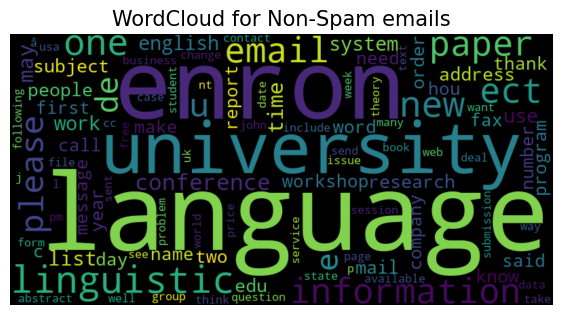

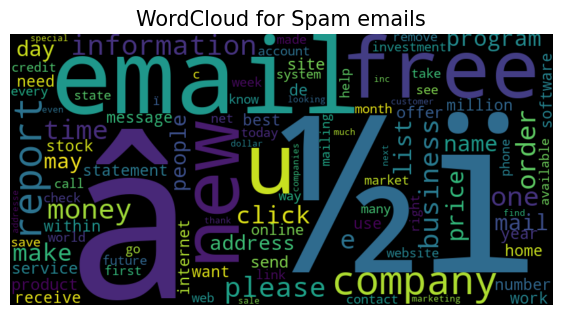

In [11]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['Body'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(df_combined[df_combined['Label'] == 0], typ='Non-Spam')
plot_word_cloud(df_combined[df_combined['Label'] == 1], typ='Spam')


### Split Data

In [12]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(df_combined['Body'],
													df_combined['Label'],
													test_size = 0.2,
													random_state = 42)


### Tokenize text

In [13]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')


### Create model

In [14]:

# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()

model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

es = EarlyStopping(patience=10,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           5499936   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5503649 (20.99 MB)
Trainable params: 5503649 (20.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train Model

In [15]:
# Train the model
history = model.fit(train_sequences, Y_train,
					validation_data=(test_sequences, Y_test),
					epochs=20,
					batch_size=32,
					callbacks = [lr, es]
				)


Epoch 1/20
467/467 [==============================] - 22s 44ms/step - loss: 0.3786 - accuracy: 0.8473 - val_loss: 0.2678 - val_accuracy: 0.9206 - lr: 0.0010
Epoch 2/20
467/467 [==============================] - 20s 42ms/step - loss: 0.1903 - accuracy: 0.9499 - val_loss: 0.1950 - val_accuracy: 0.9434 - lr: 0.0010
Epoch 3/20
467/467 [==============================] - 20s 42ms/step - loss: 0.1738 - accuracy: 0.9343 - val_loss: 0.4872 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 4/20
467/467 [==============================] - 20s 42ms/step - loss: 0.1623 - accuracy: 0.9484 - val_loss: 0.2071 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 5/20
467/467 [==============================] - 20s 42ms/step - loss: 0.1389 - accuracy: 0.9648 - val_loss: 0.2105 - val_accuracy: 0.9424 - lr: 5.0000e-04
Epoch 6/20
467/467 [==============================] - 20s 42ms/step - loss: 0.1354 - accuracy: 0.9642 - val_loss: 0.2106 - val_accuracy: 0.9424 - lr: 5.0000e-04
Epoch 7/20
467/467 [==============================

### Check accuraccy

117/117 [==============================] - 1s 5ms/step - loss: 0.2071 - accuracy: 0.9448
Test Loss : 0.207112655043602
Test Accuracy : 0.9447721242904663


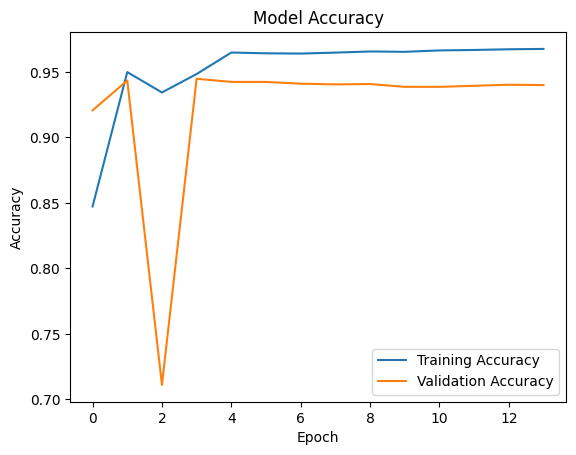

In [17]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, Y_test)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

